In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

define coupled derivatives to integrate

In [7]:
def dydx(x,y):
    #set the derivatives
    
    #our equation: d^2y/dx^2 = -y
    
    #we can write: dydx = z and dzdx = -y
    #set y = y[0]
    #set z = y[1]
    
    #declare an array 
    y_derivs = np.zeros(2)
    
    #set dydx = z
    y_derivs[0] = y[1]
    
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #retur array
    return y_derivs

def the 4th order RK method

In [11]:
def rk4_mv_core(dydx,xi,yi,nv,h):
    
    #declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    #def x at 1/2 step
    x_ipoh  = xi + 0.5*h
    
    #def x at 1 step
    x_ipo = xi + h
    
    #declare a temp y array
    y_temp = np.zeros(nv)
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #get k2 vlaues
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] + 0.5*k2[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + 0.5*k3[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k4[:] = h*y_derivs[:]
    
    #advance y by a step h
    yipo = yi + (k1 + 2*k2 + 2*k3 + k4)/6.
    
    return yipo

Def an adaptive step size driver for rk4

In [12]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    #def safty scale
    SAFTY = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of itterations
    imax = 10000
    
    #set an iteration variable 
    i = 0
    
    #create an error 
    Delta = np.full(nv,2*tol)
    
    #remember the step
    h_step = h
    
    #adjust step
    while(Delta.max()/tol > 1.0):
        
        #estimate error by taking one step of size h
        #vs two steps of size h/2
        y_2 = rk4_mv_core(dydx,x_i,y_i,nv,h_step)
        y_1 = rk4_mv_core(dydx,x_i,y_i,nv,0.5*h_step)
        y_11 = rk4_mv_core(dydx,x_i+0.5*h_step,y_1,nv,0.5*h_step)
        
        #compute error
        Delta = np.fabs(y_2 - y_11)
        
        #if the error is too large, take smaller step
        if(Delta.max()/tol > 1.0):
            
            #our error is too large, decrease the step
            h_step *= SAFTY * (Delta.max()/tol)**(-0.25)
            
        #check iteration
        if(i>=imax):
            print("To many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i =",i)
            
        #iterate
        i+=1
        
    #next time try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return the answer, a new step, and the step we took
    return y_2, h_new, h_step

Def a wrapper for RK4

In [14]:
def rk4_mv(dfdx,a,b,y_a,tol):
    
    #dfdx is the derivative wrt x
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundry conditions
    #tol is the tolerance for integrating y
    
    #def our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make really small
    h = 1.0e-4 * (b-a)
    
    #ser a max number of iterations
    imax = 10000
    
    #set itertaion variable
    i = 0
    
    #set number of coupled odes to the size of y_a
    nv = len(y_a)
    
    #set the initial conditions 
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>b):
            
            #take smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
            
            #break
            flag = 0
            
        #update the values 
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays 
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        #prevent too many iterations
        if(i>=imax):
            
            print("Max iterations reached.")
            raise StopIteration("Iteration number = i",i)
            
        #iterate 
        i += 1
        
        #output some info
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i,xi,h_step,b)
        print(s)
        
        #break if new xi is == b
        if(xi==b):
            flag = 0
            
    #return answer
    return x,y

preform integration

In [15]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#preform integration
x,y = rk4_mv(dydx,a,b,y_0,tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00886437	h = 0.00446614	b=6.28318531
i =   5	x = 0.01343975	h = 0.00457538	b=6.28318531
i =   6	x = 0.01797124	h = 0.00453149	b=6.28318531
i =   7	x = 0.02252043	h = 0.00454919	b=6.28318531
i =   8	x = 0.02706280	h = 0.00454237	b=6.28318531
i =   9	x = 0.03160823	h = 0.00454543	b=6.28318531
i =  10	x = 0.03615282	h = 0.00454460	b=6.28318531
i =  11	x = 0.04069821	h = 0.00454539	b=6.28318531
i =  12	x = 0.04524381	h = 0.00454560	b=6.28318531
i =  13	x = 0.04978991	h = 0.00454610	b=6.28318531
i =  14	x = 0.05433647	h = 0.00454656	b=6.28318531
i =  15	x = 0.05888357	h = 0.00454710	b=6.28318531
i =  16	x = 0.06343124	h = 0.00454767	b=6.28318531
i =  17	x = 0.06797954	h = 0.00454830	b=6.28318531
i =  18	x = 0.07252851	h = 0.00454897	b=6.28318531
i =  19	x = 0.07707820	h = 0.00454969	b=6.28318531
i =  20	x = 0.08162866	h = 0.00

i = 409	x = 1.93491900	h = 0.00469418	b=6.28318531
i = 410	x = 1.93961734	h = 0.00469834	b=6.28318531
i = 411	x = 1.94431991	h = 0.00470257	b=6.28318531
i = 412	x = 1.94902677	h = 0.00470686	b=6.28318531
i = 413	x = 1.95373800	h = 0.00471123	b=6.28318531
i = 414	x = 1.95845366	h = 0.00471566	b=6.28318531
i = 415	x = 1.96317382	h = 0.00472016	b=6.28318531
i = 416	x = 1.96789855	h = 0.00472473	b=6.28318531
i = 417	x = 1.97262792	h = 0.00472937	b=6.28318531
i = 418	x = 1.97736201	h = 0.00473409	b=6.28318531
i = 419	x = 1.98210088	h = 0.00473887	b=6.28318531
i = 420	x = 1.98684461	h = 0.00474373	b=6.28318531
i = 421	x = 1.99159327	h = 0.00474866	b=6.28318531
i = 422	x = 1.99634693	h = 0.00475367	b=6.28318531
i = 423	x = 2.00110568	h = 0.00475875	b=6.28318531
i = 424	x = 2.00586958	h = 0.00476390	b=6.28318531
i = 425	x = 2.01063872	h = 0.00476913	b=6.28318531
i = 426	x = 2.01541316	h = 0.00477444	b=6.28318531
i = 427	x = 2.02019299	h = 0.00477983	b=6.28318531
i = 428	x = 2.02497829	h = 0.00

i = 823	x = 3.93512377	h = 0.00539380	b=6.28318531
i = 824	x = 3.94050252	h = 0.00537875	b=6.28318531
i = 825	x = 3.94586737	h = 0.00536485	b=6.28318531
i = 826	x = 3.95121818	h = 0.00535081	b=6.28318531
i = 827	x = 3.95655531	h = 0.00533713	b=6.28318531
i = 828	x = 3.96187892	h = 0.00532361	b=6.28318531
i = 829	x = 3.96718925	h = 0.00531033	b=6.28318531
i = 830	x = 3.97248649	h = 0.00529724	b=6.28318531
i = 831	x = 3.97777085	h = 0.00528436	b=6.28318531
i = 832	x = 3.98304252	h = 0.00527167	b=6.28318531
i = 833	x = 3.98830170	h = 0.00525918	b=6.28318531
i = 834	x = 3.99354857	h = 0.00524688	b=6.28318531
i = 835	x = 3.99878334	h = 0.00523476	b=6.28318531
i = 836	x = 4.00400616	h = 0.00522283	b=6.28318531
i = 837	x = 4.00921724	h = 0.00521108	b=6.28318531
i = 838	x = 4.01441674	h = 0.00519950	b=6.28318531
i = 839	x = 4.01960483	h = 0.00518809	b=6.28318531
i = 840	x = 4.02478168	h = 0.00517685	b=6.28318531
i = 841	x = 4.02994747	h = 0.00516578	b=6.28318531
i = 842	x = 4.03510234	h = 0.00

i = 1191	x = 5.71222946	h = 0.00495667	b=6.28318531
i = 1192	x = 5.71717819	h = 0.00494873	b=6.28318531
i = 1193	x = 5.72211909	h = 0.00494090	b=6.28318531
i = 1194	x = 5.72705227	h = 0.00493318	b=6.28318531
i = 1195	x = 5.73197784	h = 0.00492557	b=6.28318531
i = 1196	x = 5.73689590	h = 0.00491806	b=6.28318531
i = 1197	x = 5.74180656	h = 0.00491066	b=6.28318531
i = 1198	x = 5.74670992	h = 0.00490336	b=6.28318531
i = 1199	x = 5.75160608	h = 0.00489616	b=6.28318531
i = 1200	x = 5.75649514	h = 0.00488907	b=6.28318531
i = 1201	x = 5.76137721	h = 0.00488207	b=6.28318531
i = 1202	x = 5.76625238	h = 0.00487517	b=6.28318531
i = 1203	x = 5.77112075	h = 0.00486837	b=6.28318531
i = 1204	x = 5.77598241	h = 0.00486166	b=6.28318531
i = 1205	x = 5.78083745	h = 0.00485505	b=6.28318531
i = 1206	x = 5.78568598	h = 0.00484853	b=6.28318531
i = 1207	x = 5.79052807	h = 0.00484210	b=6.28318531
i = 1208	x = 5.79536383	h = 0.00483576	b=6.28318531
i = 1209	x = 5.80019334	h = 0.00482951	b=6.28318531
i = 1210	x =

plot result

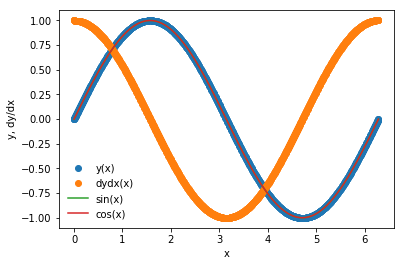

In [17]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.sin(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon=False)

Plot error

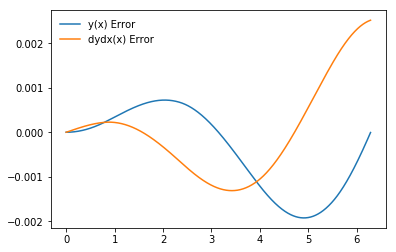

In [18]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x, y_error,label="y(x) Error")
plt.plot(x, dydx_error,label="dydx(x) Error")
plt.legend(frameon=False)